# Bước 1: Import Modules

In [1]:
!pip install py_vncorenlp

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import os
np.random.seed(0)

from pre_process import *
from utils import *

import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

## Bước 2: Import data

In [3]:
path = '.'
data_path = path + '/Data_fixed'

In [4]:
train, train_fail_images = load_file(data_path+'/Train.txt')
dev, dev_fail_images = load_file(data_path+'/Val.txt')
test, test_fail_images = load_file(data_path+'/Test.txt')

In [5]:
train

,transcription,points,text,label,link,image
0,SPY/title/0,"[[237, 673], [595, 673], [595, 540], [237, 540]]",SPY,title,0,image_0.jpg
1,ROOM/title/1,"[[618, 621], [954, 621], [954, 540], [618, 540]]",ROOM,title,1,image_0.jpg
2,LỚP HỌC ĐIỆP VIÊN/title/2,"[[621, 677], [954, 677], [954, 636], [621, 636]]",LỚP HỌC ĐIỆP VIÊN,title,2,image_0.jpg
3,"""MANAMUSUME"" GRETE/title/3","[[694, 756], [952, 756], [952, 733], [694, 733]]","""MANAMUSUME"" GRETE",title,3,image_0.jpg
4,02/title/4,"[[851, 936], [956, 936], [956, 863], [851, 863]]",02,title,4,image_0.jpg
...,...,...,...,...,...,...
53787,100.000/other/4,"[[90, 414], [178, 399], [176, 383], [88, 399]]",100.000,other,4,image_999.jpg
53788,BẢN/other/5,"[[118, 425], [151, 420], [150, 407], [117, 412]]",BẢN,other,5,image_999.jpg
53789,truyện dài/other/6,"[[285, 411], [377, 420], [381, 407], [291, 398]]",truyện dài,other,6,image_999.jpg
53790,in lần thứ 27/other/7,"[[258, 423], [372, 433], [377, 421], [263, 410]]",in lần thứ 27,other,7,image_999.jpg


In [6]:
# Drop rows with NA label
train_NonNA = train.dropna(subset=['text', 'label']).reset_index(drop=True)
dev_NonNA = dev.dropna(subset=['text', 'label']).reset_index(drop=True)
test_NonNA = test.dropna(subset=['text', 'label']).reset_index(drop=True)

## Bước 3: Chia tập dữ liệu thành X và y

In [7]:
X_train = train_NonNA['text']
y_train = train_NonNA['label']
X_dev = dev_NonNA['text']
y_dev = dev_NonNA['label']
X_test = test_NonNA['text']
y_test = test_NonNA['label']

In [8]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [9]:
y_train_encode = le.transform(y_train)
y_dev_encode = le.transform(y_dev)
y_test_encode = le.transform(y_test)

In [10]:
tags = list(le.classes_)
tags

['author', 'other', 'publisher', 'title']

## Bước 4: Xây dựng mô hình Scikit-Learn

### Tfidf vectorizer

In [12]:
tf_transformer = TfidfVectorizer()
tf_transformer.fit(X_train)

TfidfVectorizer()

In [13]:
X_train_tf = tf_transformer.transform(X_train)
X_dev_tf = tf_transformer.transform(X_dev)
X_test_tf = tf_transformer.transform(X_test)

In [14]:
saved_model_path = path + '/saved_models'

### Mô hình Naive-Bayes

In [14]:
model_nb = MultinomialNB()
model_nb.fit(X_train_tf, y_train_encode)

MultinomialNB()

In [15]:
y_pred_nb = model_nb.predict(X_test_tf)

In [16]:
print(accuracy_score(y_test_encode, y_pred_nb)*100)
print(f1_score(y_test_encode, y_pred_nb, average='macro')*100)

82.445466686452
83.7007267666198


In [17]:
print(classification_report(y_test_encode, y_pred_nb, target_names=tags))

              precision    recall  f1-score   support

      author       0.89      0.84      0.87      1070
       other       0.83      0.63      0.71      1916
   publisher       0.88      0.98      0.93       939
       title       0.78      0.90      0.84      2814

    accuracy                           0.82      6739
   macro avg       0.85      0.84      0.84      6739
weighted avg       0.83      0.82      0.82      6739



### Logistic Regression

In [18]:
log_parameters = {'penalty': ['l1', 'l2', 'elasticnet'], 'C':[1, 10, 100, 1000]}
logistic = LogisticRegression(max_iter = 250)

In [ ]:
model_log = GridSearchCV(logistic, log_parameters, scoring = 'f1_macro', cv = 10)
model_log.fit(X_train_tf, y_train_encode)

C:\Users\takhu\anaconda3\envs\NLP\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=250),
             param_grid={'C': [1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='f1_macro')

In [20]:
model_log.best_params_

{'C': 10, 'penalty': 'l2'}

In [21]:
y_pred_log = model_log.predict(X_test_tf)

In [22]:
print(accuracy_score(y_test_encode, y_pred_log)*100)
print(f1_score(y_test_encode, y_pred_log, average='macro')*100)

88.23267547113815
89.65022465741939


In [23]:
print(classification_report(y_test_encode, y_pred_log, target_names=tags))

              precision    recall  f1-score   support

      author       0.93      0.89      0.91      1070
       other       0.87      0.77      0.82      1916
   publisher       0.97      0.98      0.98       939
       title       0.85      0.92      0.88      2814

    accuracy                           0.88      6739
   macro avg       0.90      0.89      0.90      6739
weighted avg       0.88      0.88      0.88      6739



### SVM

In [31]:
model_svm = svm.SVC(kernel='rbf', gamma='scale', C=10)
model_svm.fit(X_train_tf, y_train_encode)

SVC(C=10)

In [32]:
y_pred_svm = model_svm.predict(X_test_tf)

In [33]:
print(accuracy_score(y_test_encode, y_pred_svm)*100)
print(f1_score(y_test_encode, y_pred_svm, average='macro')*100)

91.97210268585843
92.9242391283607


In [34]:
print(classification_report(y_test_encode, y_pred_svm, target_names=tags))

              precision    recall  f1-score   support

      author       0.96      0.90      0.93      1070
       other       0.92      0.84      0.88      1916
   publisher       0.98      0.99      0.99       939
       title       0.89      0.95      0.92      2814

    accuracy                           0.92      6739
   macro avg       0.94      0.92      0.93      6739
weighted avg       0.92      0.92      0.92      6739



### Save models

In [35]:
#Save naive bayes model
filename_nb = saved_model_path + '/multinb_model.sav'
pickle.dump(model_nb, open(filename_nb, 'wb'))

In [36]:
#Save logistic regression model
filename_log = saved_model_path + '/logis_model.sav'
pickle.dump(model_log, open(filename_log, 'wb'))

In [37]:
#Save svm model
filename_svm = saved_model_path + '/SVM_model.sav'
pickle.dump(model_svm, open(filename_svm, 'wb'))

## 5 Tạo pipeline cho mô hình SVM

In [38]:
pipeline_svm = Pipeline([('tfidf', TfidfVectorizer()),
                        ('SVM', svm.SVC(kernel='rbf', gamma='scale', C=10))
                        ])
pipeline_svm.fit(X_train, y_train_encode)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('SVM', SVC(C=10))])

In [39]:
y_pred_pipe = pipeline_svm.predict(X_test)

In [40]:
print(accuracy_score(y_test_encode, y_pred_pipe)*100)
print(f1_score(y_test_encode, y_pred_pipe, average='macro')*100)

91.97210268585843
92.9242391283607


In [41]:
print(classification_report(y_test_encode, y_pred_pipe, target_names=tags))

              precision    recall  f1-score   support

      author       0.96      0.90      0.93      1070
       other       0.92      0.84      0.88      1916
   publisher       0.98      0.99      0.99       939
       title       0.89      0.95      0.92      2814

    accuracy                           0.92      6739
   macro avg       0.94      0.92      0.93      6739
weighted avg       0.92      0.92      0.92      6739



In [42]:
#Save pipeline
filename_pipe = saved_model_path + '/SVM_pipeline.sav'
pickle.dump(pipeline_svm, open(filename_pipe, 'wb'))

## 6 Phân tích lỗi

In [15]:
filename_svm = saved_model_path + '/SVM_model.sav'

In [16]:
loaded_model_svm = pickle.load(open(filename_svm, 'rb'))

In [25]:
y_test_pred = loaded_model_svm.predict(X_test_tf)

In [18]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test_encode, y_test_pred)

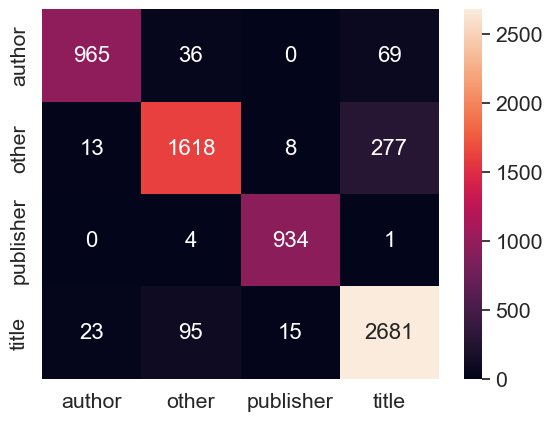

In [19]:
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cf, range(4), range(4))
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', 
           xticklabels=tags, yticklabels=tags) 
plt.show()

In [20]:
def failed_examples(data, true, predict, y_true, y_pred):
  failed = (y_pred != y_true)
  data_failed = data[failed].reset_index(drop=True)
  return data_failed[np.logical_and((y_true[failed] == true), (y_pred[failed] == predict))]

### Check the errors between `title` and `other`

In [32]:
failed_examples(test_NonNA, true=3, predict=1, y_true=y_test_encode, y_pred=y_test_pred)

,transcription,points,text,label,link,image
6,Step by Step/title/2,"[[70, 835], [483, 784], [479, 710], [70, 742]]",Step by Step,title,2,image_1074.jpg
8,DẠY CON/title/0,"[[379, 452], [703, 453], [709, 361], [379, 348]]",DẠY CON,title,0,image_1081.jpg
13,Tinh/title/3,"[[401, 927], [768, 871], [778, 714], [425, 752]]",Tinh,title,3,image_1114.jpg
17,ỨNG DỤNG/title/0,"[[504, 426], [712, 426], [712, 379], [504, 379]]",ỨNG DỤNG,title,0,image_113.jpg
19,NÃO BỘ/title/0,"[[120, 928], [815, 960], [818, 779], [134, 760]]",NÃO BỘ,title,0,image_1280.jpg
...,...,...,...,...,...,...
479,KỸ NĂNG SỐNG/title/1,"[[438, 1036], [2684, 1084], [2650, 1552], [412...",KỸ NĂNG SỐNG,title,1,image_7177.jpg
481,ĐỪNG BÁN/title/0,"[[259, 333], [670, 345], [670, 476], [258, 466]]",ĐỪNG BÁN,title,0,image_7282.jpg
496,SAU/title/1,"[[412, 645], [560, 619], [569, 667], [421, 694]]",SAU,title,1,image_759.jpg
515,khi trở thành/title/4,"[[216, 387], [342, 376], [347, 411], [213, 427]]",khi trở thành,title,4,image_854.jpg


In [33]:
failed_examples(test_NonNA, true=1, predict=3, y_true=y_test_encode, y_pred=y_test_pred)

,transcription,points,text,label,link,image
0,TRẦN HOA dị/other/3,"[[771, 746], [933, 748], [932, 720], [769, 714]]",TRẦN HOA dị,other,3,image_1006.jpg
1,Chữa lành/other/2,"[[102, 1170], [187, 1169], [187, 1150], [101, ...",Chữa lành,other,2,image_1048.jpg
3,"10, 11, 12/other/1","[[252, 845], [394, 842], [395, 766], [255, 772]]","10, 11, 12",other,1,image_1066.jpg
7,Fiel thực hành/other/6,"[[99, 588], [193, 590], [194, 576], [99, 572]]",Fiel thực hành,other,6,image_1074.jpg
9,PHÁT TRIỂN DOANH NGHIỆP THÀNH CÔNG/other/3,"[[213, 932], [836, 942], [834, 907], [213, 897]]",PHÁT TRIỂN DOANH NGHIỆP THÀNH CÔNG,other,3,image_1106.jpg
...,...,...,...,...,...,...
527,Tự chủ về tài chính/other/5,"[[448, 844], [601, 836], [601, 858], [449, 864]]",Tự chủ về tài chính,other,5,image_896.jpg
534,học sinh giỏi/other/3,"[[210, 596], [305, 595], [302, 618], [213, 614]]",học sinh giỏi,other,3,image_915.jpg
538,THAY ĐỔI/other/1,"[[723, 946], [823, 946], [823, 924], [723, 924]]",THAY ĐỔI,other,1,image_972.jpg
539,CUỘC ĐỜI/other/2,"[[722, 975], [825, 975], [825, 950], [722, 950]]",CUỘC ĐỜI,other,2,image_972.jpg


### Check the errors between `title` and `author`

In [34]:
failed_examples(test_NonNA, true=0, predict=3, y_true=y_test_encode, y_pred=y_test_pred)

,transcription,points,text,label,link,image
4,PHẠM TRỌNG THƯ/author/0,"[[271, 444], [386, 443], [384, 461], [270, 462]]",PHẠM TRỌNG THƯ,author,0,image_1066.jpg
12,Simona Covel/author/0,"[[373, 155], [642, 135], [642, 106], [373, 130]]",Simona Covel,author,0,image_1106.jpg
14,THẦY HỒ ĐỨC THUẬN/author/0,"[[384, 329], [583, 317], [581, 287], [383, 298]]",THẦY HỒ ĐỨC THUẬN,author,0,image_1116.jpg
20,EAGLEMAN/author/1,"[[140, 696], [630, 711], [630, 653], [142, 643]]",EAGLEMAN,author,1,image_1280.jpg
25,Lời: Trần Linh Linh/author/0,"[[84, 658], [200, 657], [200, 643], [83, 646]]",Lời: Trần Linh Linh,author,0,image_1308.jpg
...,...,...,...,...,...,...
529,Bryce Leung/author/1,"[[231, 318], [385, 285], [385, 325], [234, 356]]",Bryce Leung,author,1,image_896.jpg
532,MINH/author/1,"[[418, 737], [512, 740], [515, 760], [418, 762]]",MINH,author,1,image_898.jpg
533,viết/author/2,"[[468, 771], [515, 766], [513, 789], [469, 789]]",viết,author,2,image_898.jpg
535,TRANG/author/0,"[[352, 103], [451, 101], [454, 121], [356, 121]]",TRANG,author,0,image_915.jpg


In [35]:
failed_examples(test_NonNA, true=3, predict=0, y_true=y_test_encode, y_pred=y_test_pred)

,transcription,points,text,label,link,image
70,TRÍ/title/1,"[[796, 645], [1042, 713], [1010, 823], [764, 7...",TRÍ,title,1,image_1985.jpg
71,TRÍ/title/1,"[[549, 654], [859, 628], [872, 779], [562, 806]]",TRÍ,title,1,image_1988.jpg
131,NGUYỄN/title/0,"[[659, 976], [2369, 825], [2366, 1236], [671, ...",NGUYỄN,title,0,image_3300.jpg
133,NGUYỄN/title/0,"[[708, 1363], [2220, 1375], [2190, 1720], [687...",NGUYỄN,title,0,image_3301.jpg
142,dương/title/1,"[[1125, 903], [1868, 929], [1794, 1182], [964,...",dương,title,1,image_3440.jpg
155,Hồng/title/0,"[[2026, 1120], [2694, 1452], [2576, 1734], [19...",Hồng,title,0,image_3636.jpg
157,Hồng/title/0,"[[1600, 1273], [2265, 1305], [2300, 1524], [15...",Hồng,title,0,image_3638.jpg
159,Hồng/title/0,"[[2328, 470], [3021, 530], [3036, 838], [2321,...",Hồng,title,0,image_3639.jpg
177,trí/title/3,"[[558, 348], [636, 311], [716, 347], [572, 478]]",trí,title,3,image_4064.jpg
196,ĐÌNH/title/5,"[[450, 855], [838, 817], [846, 973], [446, 978]]",ĐÌNH,title,5,image_4175.jpg


### Check the errors between `author` and `other`

In [36]:
failed_examples(test_NonNA, true=0, predict=1, y_true=y_test_encode, y_pred=y_test_pred)

,transcription,points,text,label,link,image
5,"(GV chuyên Toán, Trường THPT chuyên/author/1","[[179, 226], [498, 247], [497, 223], [178, 203]]","(GV chuyên Toán, Trường THPT chuyên",author,1,image_1069.jpg
16,"(Giáo viên chuyên Anh, Trường Quốc học Huế)/au...","[[238, 220], [575, 186], [574, 155], [238, 201]]","(Giáo viên chuyên Anh, Trường Quốc học Huế)",author,1,image_1128.jpg
106,Thái Phạm - Trương Minh Huy - Đỗ Phan Thu H...,"[[428, 905], [840, 903], [839, 925], [431, 928]]",Thái Phạm - Trương Minh Huy - Đỗ Phan Thu Hà,author,0,image_277.jpg
121,Nguyễn Như Quỳnh/author/1,"[[535, 229], [671, 228], [671, 248], [534, 252]]",Nguyễn Như Quỳnh,author,1,image_304.jpg
130,Công/author/1,"[[1697, 788], [2386, 835], [2376, 1089], [1685...",Công,author,1,image_3253.jpg
143,Thành/author/0,"[[1355, 325], [1951, 251], [1994, 438], [1373,...",Thành,author,0,image_3440.jpg
156,Hào/author/0,"[[2163, 916], [2355, 1011], [2311, 1097], [212...",Hào,author,0,image_3636.jpg
158,Hào/author/0,"[[1648, 1125], [1834, 1131], [1840, 1194], [16...",Hào,author,0,image_3638.jpg
160,Hào/author/0,"[[2371, 247], [2564, 251], [2572, 349], [2377,...",Hào,author,0,image_3639.jpg
161,TÁC GIẢ/author/0,"[[1977, 813], [2435, 929], [2406, 1052], [1946...",TÁC GIẢ,author,0,image_3658.jpg


In [37]:
failed_examples(test_NonNA, true=1, predict=0, y_true=y_test_encode, y_pred=y_test_pred)

,transcription,points,text,label,link,image
2,"BỒI DƯỠNG HS KHÁ, GIỎI LỚP/other/0","[[265, 758], [399, 754], [400, 739], [265, 743]]","BỒI DƯỠNG HS KHÁ, GIỎI LỚP",other,0,image_1066.jpg
48,BỘ GIÁO DỤC VÀ ĐÀO TẠO/other/2,"[[507, 188], [1072, 275], [1075, 342], [501, 2...",BỘ GIÁO DỤC VÀ ĐÀO TẠO,other,2,image_1793.jpg
74,Vũ/other/2,"[[839, 399], [901, 424], [878, 469], [822, 441]]",Vũ,other,2,image_2005.jpg
96,85 Trần Đại Nghĩa - HBT - HN/other/0,"[[48, 53], [220, 52], [220, 73], [49, 72]]",85 Trần Đại Nghĩa - HBT - HN,other,0,image_232.jpg
201,(Nguyên Trưởng bộ môn Phương pháp dạy Toán Tiể...,"[[401, 120], [800, 92], [802, 120], [401, 146]]",(Nguyên Trưởng bộ môn Phương pháp dạy Toán Tiể...,other,0,image_4263.jpg
233,Thiết lập/other/5,"[[339, 888], [398, 890], [401, 908], [339, 906]]",Thiết lập,other,5,image_4427.jpg
277,"Nguyễn Đình Hách, Nguyễn Tiến Quang/other/1","[[1110, 2826], [2210, 2816], [2210, 2885], [11...","Nguyễn Đình Hách, Nguyễn Tiến Quang",other,1,image_5048.jpg
367,Dương Hoàng Thanh Giang/other/1,"[[283, 1191], [598, 1193], [601, 1229], [281, ...",Dương Hoàng Thanh Giang,other,1,image_5696.jpg
372,TOM PLATE BÀN VỀ CHÂU Á/other/1,"[[119, 620], [364, 616], [364, 640], [122, 637]]",TOM PLATE BÀN VỀ CHÂU Á,other,1,image_5746.jpg
401,House/other/9,"[[379, 1076], [434, 1075], [434, 1059], [378, ...",House,other,9,image_5843.jpg


### Nhận xét: 
- Phần lớn các lỗi nhầm lẫn đều khó phân biệt và không thể chỉ dựa vào text. Có lẽ việc đưa thêm tọa độ bounding box vào input sẽ cho ra kết quả chính xác hơn.
- Bộ dữ liệu còn một số vấn đề, nhiều trường hợp cùng 1 tình huống nhưng kết quả lại khác nhau, đặc biệt là các tình huống giữa 2 nhãn `author` và `other`